# **Data Visualizaton**

## Objectives
Business rquirement 1:

* The client is interested in conducting a study to visually differentiate a cherry leaf that is healthy from one that contains powdery mildew.

## Inputs

* Data from test, train and validation folders

## Outputs

* Process imagem shape
* Visualizing image mean and variability
* Establishing a distinction between healthy and infected cherry leaves
* Creating code to address business requirement 1 and enable image montage for the Streamlit dashboard.


---

## Import necessary libraries

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
import numpy as np
from matplotlib.image import imread
import joblib

---

# Set working directory

Change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [3]:
cwd= os.getcwd()

In [4]:
os.chdir('/workspaces/mildew_detection')
print("Changed working directory to:", os.getcwd())


Changed working directory to: /workspaces/mildew_detection


Get the current directory

In [5]:
work_dir = os.getcwd()
work_dir

'/workspaces/mildew_detection'

* #### Set input directories

In [6]:
my_data_dir = 'inputs/cherryleaves_dataset/cherry-leaves'
train_path = os.path.join(my_data_dir, 'train')
validation_path = os.path.join(my_data_dir, 'validation')
test_path = os.path.join(my_data_dir, 'test')

* #### Set output directories

In [7]:
version = 'v1'
file_path = f'outputs/{version}'

* #### Check if previous version is available

In [8]:
if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
  print('Old version is already available, Create a new version.')
  pass
else:
  os.makedirs(name=file_path)

Old version is already available, Create a new version.


* #### Set label

In [9]:
labels = os.listdir(train_path)
print('Label for the images are',labels)

Label for the images are ['powdery_mildew', 'healthy']


---

# Data Visualization

* #### Compute average images size on train set

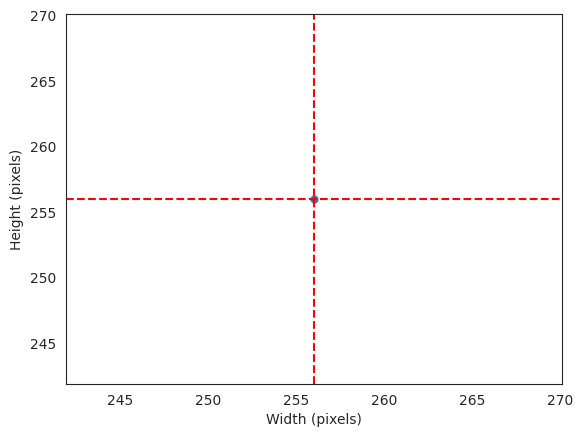

Width average: 256 
Height average: 256


In [10]:
dim1, dim2 = [], []
for label in labels:
    for image_filename in os.listdir(train_path + '/' + label):
        img = imread(train_path + '/' + label + '/' + image_filename)
        d1, d2, colors = img.shape
        dim1.append(d1)  # image height
        dim2.append(d2)  # image width

fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean, color='r', linestyle='--')
axes.axhline(y=dim2_mean, color='r', linestyle='--')
plt.show()
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")

* #### Image size for training the model is the average from all mages in the train set

In [11]:
image_shape = (dim1_mean, dim2_mean, 3)
print("Image shape for training:", image_shape)

Image shape for training: (256, 256, 3)


* #### Save the image shape embeddings

In [12]:
joblib.dump(value=image_shape ,
            filename=f"{file_path}/image_shape.pkl")

['outputs/v1/image_shape.pkl']

# Average and variability of images per label

* #### Load images into an array (Tensor)

In [13]:
from tensorflow.keras.preprocessing import image

In [14]:
def load_image_as_array(my_data_dir, new_size=(50, 50), n_images_per_label=20):
    
    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    labels = os.listdir(my_data_dir)

    for label in labels:
        counter = 0
        for image_filename in os.listdir(os.path.join(my_data_dir, label)):
            if counter < n_images_per_label:
                img = image.load_img(
                    os.path.join(my_data_dir, label, image_filename), target_size=new_size)
                img_resized = image.img_to_array(img) / 255
                X = np.append(X, img_resized).reshape(-1,
                                                      new_size[0], new_size[1], img_resized.shape[2])
                y = np.append(y, label)
                counter += 1

    return X, y

* #### Load image shapes ans labels in an array

In [15]:
X, y = load_image_as_array(my_data_dir=train_path,
                           new_size=image_shape,
                           n_images_per_label=30)
print(X.shape, y.shape)

(60, 256, 256, 3) (60,)


---

* #### Plot the mean and variability of images per label

In [16]:
def plot_mean_variability_per_labels(X, y, figsize=(12, 5), save_image=False):
    """
    The pseudo-code for the function is:
    * Loop over all labels
    * Subset an array for a given label
    * Calculate the mean and standard deviation
    * Create a figure displaying the mean and variability of images
    * Save the image
    """

    for label_to_display in np.unique(y):

        y = y.reshape(-1, 1, 1)
        boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
        arr = X[boolean_mask]

        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)
        print(f"==== Label {label_to_display} ====")
        print(f"Image Shape: {avg_img.shape}")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average image for label {label_to_display}")
        axes[0].imshow(avg_img, cmap='gray')
        axes[1].set_title(f"Variability image for label {label_to_display}")
        axes[1].imshow(std_img, cmap='gray')

        if save_image:
            plt.savefig(f"{file_path}/avg_var_{label_to_display}.png",
                        bbox_inches='tight', dpi=150)
        else:
            plt.tight_layout()
            plt.show()
            print("\n")

==== Label healthy ====
Image Shape: (256, 256, 3)
==== Label powdery_mildew ====
Image Shape: (256, 256, 3)


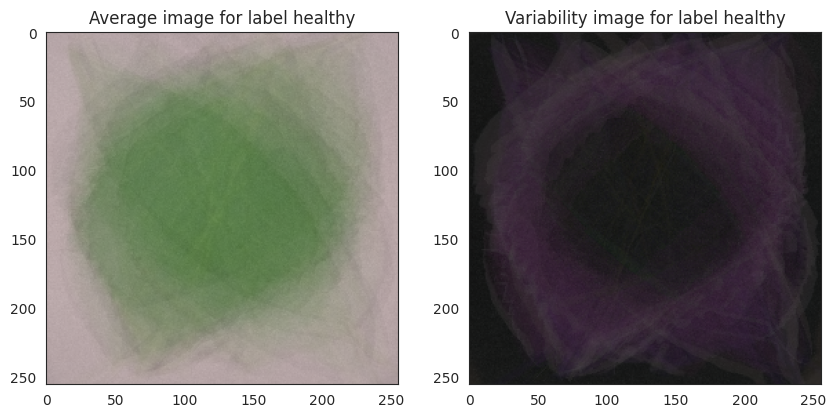

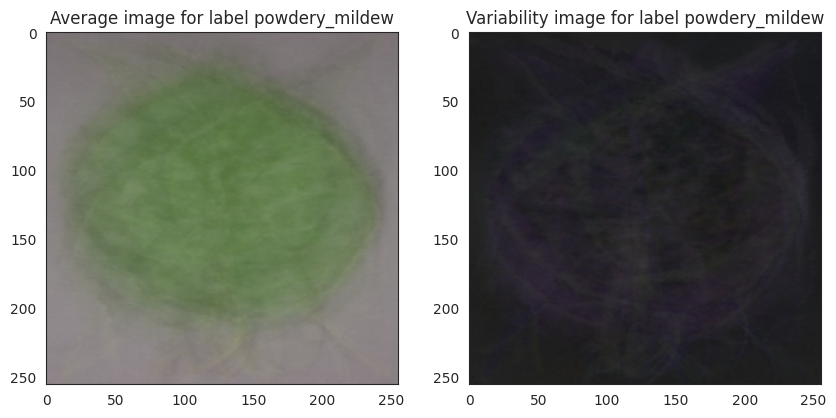

In [17]:
plot_mean_variability_per_labels(X=X, y=y, figsize=(10, 5), save_image=True)

---

* #### Get a subset of images for a given label

In [18]:
def subset_image_label(X, y, label_to_display):
    y_reshaped = y.reshape(-1, 1, 1)
    boolean_mask = np.any(y_reshaped == label_to_display, axis=1).reshape(-1)
    df = X[boolean_mask]
    return df

* #### Calculate and plot the difference between the average images of two labels

In [ ]:
def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, figsize=(20, 5), save_image=False):
    """
    Checks if the labels exist in the set of unique labels
    Calculates the mean and difference for label1 and label2
    Plots a chart and saves it if save_image=True
    """
    sns.set_style("white")

    if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
        print(
            f"Either label {label} or label {label_2}, are not in {np.unique(y)} ")
        return

    # calculate mean from label1
    images_label = subset_image_label(X, y, label_1)
    label1_avg = np.mean(images_label, axis=0)

    # calculate mean from label2
    images_label = subset_image_label(X, y, label_2)
    label2_avg = np.mean(images_label, axis=0)

    # calculate difference and plot difference, avg label1 and avg label2
    difference_mean = label1_avg - label2_avg
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    axes[0].imshow(label1_avg, cmap='gray')
    axes[0].set_title(f'Average {label_1}')
    axes[1].imshow(label2_avg, cmap='gray')
    axes[1].set_title(f'Average {label_2}')
    axes[2].imshow(difference_mean, cmap='gray')
    axes[2].set_title(f'Difference image: Avg {label_1} & {label_2}')
    if save_image:
        plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=150)
    else:
        plt.tight_layout()
        plt.show()

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* If you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
    # create here your folder
    # os.makedirs(name='')
except Exception as e:
    print(e)
